Replicating micrograd from https://github.com/karpathy/nn-zero-to-hero/blob/master/lectures/micrograd/micrograd_lecture_first_half_roughly.ipynb

In [433]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [434]:
def f(x):
    return 3*x**2 - 4*x + 5

In [435]:
f(3.0)

20.0

In [436]:
def print_and_return(x):
    print(x)
    return x

[-5.   -4.75 -4.5  -4.25 -4.   -3.75 -3.5  -3.25 -3.   -2.75 -2.5  -2.25
 -2.   -1.75 -1.5  -1.25 -1.   -0.75 -0.5  -0.25  0.    0.25  0.5   0.75
  1.    1.25  1.5   1.75  2.    2.25  2.5   2.75  3.    3.25  3.5   3.75
  4.    4.25  4.5   4.75]
[100.      91.6875  83.75    76.1875  69.      62.1875  55.75    49.6875
  44.      38.6875  33.75    29.1875  25.      21.1875  17.75    14.6875
  12.       9.6875   7.75     6.1875   5.       4.1875   3.75     3.6875
   4.       4.6875   5.75     7.1875   9.      11.1875  13.75    16.6875
  20.      23.6875  27.75    32.1875  37.      42.1875  47.75    53.6875]


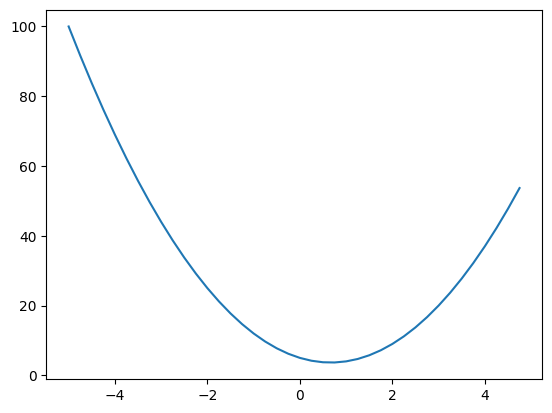

In [437]:
import matplotlib.pyplot as plt
xs = print_and_return(np.arange(-5, 5, 0.25))
ys = print_and_return(f(xs))
plt.plot(xs, ys)

In [438]:
# dervative examples how value is changing in slope
h = 0.0001
a = 2.0
b = -3.0
c = 10.0
d1 = a*b + c
c += h
d2 = a*b + c
print("d1", d1)
print("d2", d2)
print("slope", (d2 - d1) / h)

d1 4.0
d2 4.0001
slope 0.9999999999976694


In [439]:
class Value:

    def __init__(self, data, _children=(), _op = '', label = ''):
        self.data = data
        self._prev = set(_children)
        self._op = _op
        self.label = label
        self.grad = 0.0
        self._backward = lambda: None

    def __repr__(self):
        return f"Value(data = {self.data})"

    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), '+')
        def backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad
        out._backward = backward

        return out
    
    def __radd__(self, other):
        return self * other

    def __rmul__(self, other):
        return self * other
    
    def __neg__(self):
        return self * -1.0
    
    def __sub__(self, other):        
        return self + (-other)

    def __pow__(self, other):
        assert isinstance(other, int) or isinstance(other, float)
        out = Value(self.data ** other, (self,), 'pow')
        def backward():
            self.grad += other * self.data ** (other - 1) * out.grad

        out._backward = backward
        return out
    
    def __truediv__(self, other):
        return self * (other ** -1.0)
    
    def exp(self):
        out = Value(math.exp(self.data), (self,), 'exp')
        def backward():
            self.grad += out.data * out.grad
        out._backward = backward
        return out


    def backward(self):
        t_sorted = []
        visited = set()
        def topological_sort(node):
            if node not in visited:
                visited.add(node)
                for c in node._prev:
                    topological_sort(c)
                t_sorted.append(node)

        topological_sort(self)

        self.grad = 1.0
        for node in reversed(t_sorted):
            node._backward()

    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other), '*')
        def backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = backward
        return out
    
    def tanh(self):
        x = self.data
        t = (math.exp(2 * x) - 1) / (math.exp(2 * x) + 1) 
        out = Value(t, (self,), 'tanh')
        def backward():
            self.grad += out.grad * (1 - t ** 2)
        out._backward = backward
        return out




In [440]:
from graphviz import Digraph

def trace(root):
  # builds a set of all nodes and edges in a graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right
  
  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for any value in the graph, create a rectangular ('record') node for it
    dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
    if n._op:
      # if this value is a result of some operation, create an op node for it
      dot.node(name = uid + n._op, label = n._op)
      # and connect this node to it
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot

In [441]:
#sigle neuron
#inputs
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

#weights
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

#bias
b = Value(6.8813735870, label='b')

# Forward pass
x1w1 = x1 * w1 
x1w1.label = 'x1w1'
x2w2 = x2 * w2
x2w2.label = 'x2w2'
x1w1x2w2 = x1w1 + x2w2
x1w1x2w2.label = 'x1w1x2w2'

n = x1w1x2w2 + b 
n.label = 'n'
o = n.tanh()
o.label = 'o'


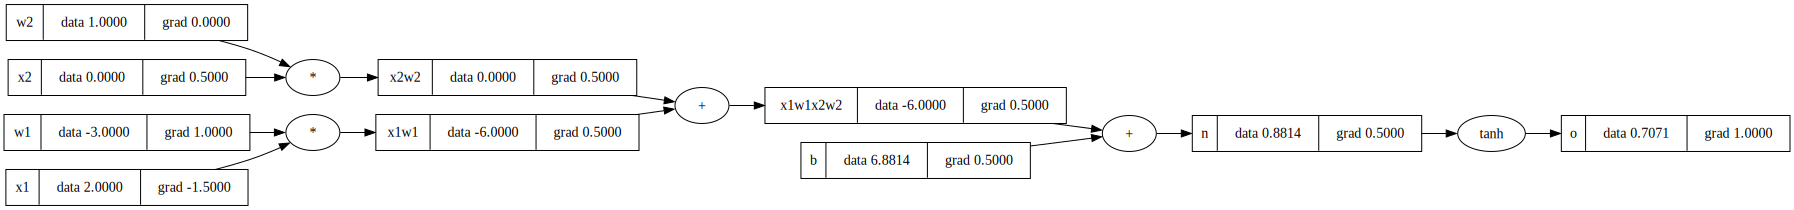

In [442]:
o.backward()
draw_dot(o)

In [443]:
#sigle neuron
#inputs
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

#weights
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

#bias
b = Value(6.8813735870, label='b')

# Forward pass
x1w1 = x1 * w1 
x1w1.label = 'x1w1'
x2w2 = x2 * w2
x2w2.label = 'x2w2'
x1w1x2w2 = x1w1 + x2w2
x1w1x2w2.label = 'x1w1x2w2'

n = x1w1x2w2 + b 
n.label = 'n'
e = (2*n).exp()
o = (e - 1) / (e + 1)
o.label = 'o'

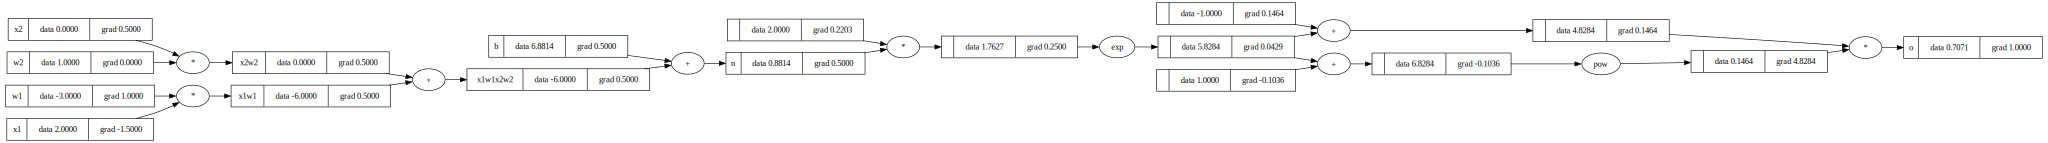

In [444]:
o.backward()
draw_dot(o)

In [445]:
import torch
t_x1 = torch.tensor(2.0)
t_x1.requires_grad = True
t_x2 = torch.tensor(0.0)
t_x2.requires_grad = True
t_w1 = torch.tensor(-3.0)
t_w1.requires_grad = True
t_w2 = torch.tensor(1.0)
t_w2.requires_grad = True
t_b = torch.tensor(6.8813735870)
t_b.requires_grad = True
t_n = t_x1 * t_w1 + t_x2 * t_w2 + t_b
t_o = torch.tanh(t_n)
t_o.backward()
print(t_w1.grad.item())
print(t_x1.grad.item())
print(t_w2.grad.item())
print(t_x2.grad.item())
print(t_b.grad.item())


1.000000238418579
-1.5000003576278687
0.0
0.5000001192092896
0.5000001192092896


In [446]:
import random
from typing import Any
class Neuron():
    def __init__(self, number_of_inputs):
        self.weights = [Value(random.uniform(-1,1),label = 'w') for i in range(number_of_inputs)]
        self.bias = Value(random.uniform(-1,1))

    def parameters(self):
        return self.weights + [self.bias]

    def __repr__(self) -> str:
        return f'Neuron(weights={self.weights}, bias={self.bias})'

    def __call__(self, x):
        all_values = zip(self.weights, x)
        act = sum((w*v for w,v in all_values) , self.bias)
        out = act.tanh()
        return out
    
class Layer():
    def __init__(self, number_of_inputs, number_of_neurons_per_layer):
        self.neurons = [Neuron(number_of_inputs) for i in range(number_of_neurons_per_layer)]

    def parameters(self):
        return [p for n in self.neurons for p in n.parameters()]
    
    def __repr__(self) -> str:
        return f'Layer(neurons={self.neurons})'

    def __call__(self, x):
        return [n(x) for n in self.neurons]

class MultiLayerPerceptron():
    # number_of_neurons_per_layer is a list of expected neurons per layer
    def __init__(self, number_of_inputs, number_of_neurons_per_layer):
        # combining inputs and outputs
        sz = [number_of_inputs] + number_of_neurons_per_layer
        # sz[i] is input and sz[i+1] is number of neurons in layer
        # in next iteration sz[i+1] becomes number of inputs because 
        # each neuron from previos iteration has an output
        self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(number_of_neurons_per_layer))]

    def parameters(self):
        return [p for l in self.layers for p in l.parameters()]

    def __repr__(self) -> str:
        return f'MulitLayerPerceptron(layers={self.layers})'

    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x[0] if len(x) == 1 else x



In [447]:
mlp = MultiLayerPerceptron(3, [4,4,1])

In [448]:
# samnple data for binary classification
xs = [
  [2.0, 3.0, -1.0],
  [3.0, -1.0, 0.5],
  [0.5, 1.0, 1.0],
  [1.0, 1.0, -1.0],
]
ys = [1.0, -1.0, -1.0, 1.0] # desired targets

In [449]:
for i in range(1000):
    yspred = [mlp(x) for x in xs]
    loss = sum([(p_output - p_expected)**2 for p_expected, p_output in zip(ys, yspred)])
    # ensure to 0 grad
    for p in mlp.parameters():
        p.grad = 0.0
    
    loss.backward()
    for p in mlp.parameters():
        p.data += -0.05 * p.grad
    print(f'Current iteration loss is: {loss} with predicion: {yspred}')

Current iteration loss is: Value(data = 7.261014824785901) with predicion: [Value(data = 0.0070304019950792355), Value(data = 0.9507003941805281), Value(data = 0.6117875402110066), Value(data = 0.07375828092749713)]
Current iteration loss is: Value(data = 5.689332070346171) with predicion: [Value(data = 0.0463694111418153), Value(data = 0.9408397198235601), Value(data = 0.2037833092952695), Value(data = 0.311974566921029)]
Current iteration loss is: Value(data = 4.517448823595596) with predicion: [Value(data = -0.075407288241938), Value(data = 0.9115344951629238), Value(data = -0.2982411893271608), Value(data = 0.3908864891985538)]
Current iteration loss is: Value(data = 3.805486620853083) with predicion: [Value(data = -0.07867841165245676), Value(data = 0.8179799631326836), Value(data = -0.5042496838423491), Value(data = 0.4953544823039066)]
Current iteration loss is: Value(data = 1.475123151490945) with predicion: [Value(data = -0.13215307816484995), Value(data = 0.04182745883254012)